# Slit through focus analysis for SM3 slit alignment 

**Creator :** Fabrice MADEC *(Laboratoire d'astrophysique de Marseille)*

**Editor :** Romain LHOUSSAINE BEN BRAHIM *(Laboratoire d'astrophysique de Marseille)*

**Date :** February 19th, 2021 ***[Closed on March, 3 2021]***

**Data required:** You need to use ics_spsaitActor to perform your sequence,get the data required acquisitions to plot the through focus from the slit, and being able to find the right focus.

    Example : slit throughfocus exptime=6.0 lowBound=-0.5 upBound=1.5 fiber=engbotend nbPosition=10 duplicate=1
    (lowBound and upBound are the ranges of the slit focus)

## 0. Librairies, constants and parameters

### 0.1. Classic librairies

In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import os
import datetime
from matplotlib import style

### 0.2. LAM Librairies

In [2]:
# import LAM library for logbook, data analysis...
from pfs.lam.sacFileHandling import Logbook, constructFilelist
import pfs.lam.imageAnalysis as imeas
from pfs.lam.slitFocusAnalysis import *
from pfs.lam.style import colors

### 0.3. Constants & parameters

In [3]:
# Style sheets reference
style.use('ggplot')

In [4]:
# Distance between engtopend & engbotend fibers
CST_DIST_FIBERS = 138.84

In [5]:
smId = 3

In [6]:
imgPath = f"/home/pfs/shared/Pictures/SM{smId}/slitAlign/" # WARNING : You must verify that you are choosing the right SM folder !!

## 1. Downloading Data

### 1.0. Theorical Zeemax data

In [7]:
# Filepath of data model
pmodel = os.environ['LAM_SPS_ANALYSIS_DIR']+"/notebooks/optical/input/slit"
file = 'slit-defParam-Ouverture100-fiber65.csv'

In [8]:
# 1: Loading Zeemax data
zemaxData = pd.read_csv('%s/%s' % (pmodel, file), delimiter=" ")

In [9]:
# 2: Loading Zeemax data for medium fibers
zemaxMidFit = imeas.fitparabola(x=zemaxData.Slitdefocus, y=zemaxData.MidFiber, deg=15, focus='max')

In [10]:
# 3: Loading Zeemax data for extreme fibers
zemaxEndFit = imeas.fitparabola(x=zemaxData.Slitdefocus, y=zemaxData.ExtremeFiber, deg=15, focus='max')

### 1.1. Experimental data

In [11]:
# Loading data from the data base
experiments = pd.read_sql_query('select * from Experiment where type="slitAlignment" order by experimentId desc',
                                con='sqlite:////data/ait/experimentLog-sac.db', index_col='experimentId')

In [12]:
# Data manipulation
experiments['exptime'] = [Logbook.getParameter(experimentId, 'exptime') for experimentId in experiments.index]
experiments['fiber'] = [Logbook.getParameter(experimentId, 'fiber', doRaise=False) for experimentId in experiments.index]

In [13]:
# Display of the 5 last acquisitions made on the SacSequence Panel
experiments.head()

,name,visitStart,visitEnd,type,cmdStr,comments,anomalies,startdate,cmdError,exptime,fiber
experimentId,,,,,,,,,,,
468,SM3_Slit_Alignment,14437,14496,slitAlignment,"spsait slit align exptime=4.0 position=-1.5,2....",halogen mask 125mm,,2021-03-02T10:12:33,,4.0,scibotend
467,SM3_Slit_Alignment,14377,14436,slitAlignment,"spsait slit align exptime=4.0 position=-1.5,2....",halogen mask 125mm,,2021-03-02T09:48:42,,4.0,scibotmid
466,SM3_Slit_Alignment,14317,14376,slitAlignment,"spsait slit align exptime=4.0 position=-1.5,2....",halogen mask 125mm,,2021-03-02T09:24:40,,4.0,scitopmid
465,SM3_Slit_Alignment,14257,14316,slitAlignment,"spsait slit align exptime=4.0 position=-1.5,2....",halogen mask 125mm,,2021-03-02T09:00:35,,4.0,scitopend
464,SM3_Slit_Alignment,14181,14240,slitAlignment,"spsait slit align exptime=1.0 position=-1.5,2....",halogen mask 125mm,,2021-02-19T10:36:38,,1.0,engbotend


## 2. Data Analysis

### 2.1. Input Parameters : 

The only parameters needed is the experimentIds that match your data acquisition sequence.

In [14]:
#All the experiment Ids used for SM3 slit Alignement

# First analysis on engineering fibers
#experimentIds = [447,448,449,450]     # Ids needed for the slit through focus analysis

# Second analysis on engineering fibers : after the first correction
#experimentIds = [461,462,463,464]     # Ids needed for the slit through focus analysis

# Analysis on scientific fibers to confirm the correction
experimentIds = [465,466,467,468]     # Ids needed for the slit through focus analysis

In [15]:
com           = True                  #
doBck         = True                  #
corrector     = False                 #
doSave        = True                  # Parameter that allow to save the through slit focus on the distant computer 
head          = 0                     #
tail          = 0                     #
dfs           = []                    #
#bck_expId     = 260                   #

In [16]:
threshold = 300                   #
radius = 60                       #
doPrint = False                   #
doPlot = False                    #
roi_size = 150                    #


In [17]:
fwhm_radius = radius              #
fwhm_method = 'gaussian'          #

In [18]:
vline = True
plotModel = True
index = 'fca_x'

In [19]:
criteria = 'EE40'
EE = 20
if criteria == 'EE40' :
    EE      = 40

In [20]:
thres_neighbor = -0.1
doNeighborFilter = True

### 2.2. Compile the maximum brightness according to the focus's displacement

/software/drp/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/scipy/optimize/minpack.py:447: RuntimeWarning: Number of calls to function has reached maxfev = 800.
  warnings.warn(errors[info][0], RuntimeWarning)
/home/rlhoussaine/devel/lam_sps_analysis/python/pfs/lam/imageAnalysis.py:148: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(ee)/np.sum(roi), np.sum(roi)


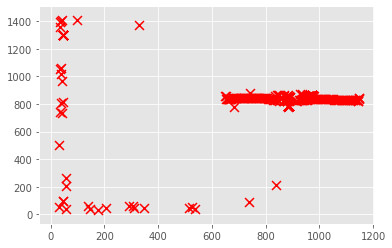

In [21]:
for experimentId in experimentIds:
    visitStart, visitEnd = Logbook.visitRange(experimentId=experimentId)
    filelist = constructFilelist(visitStart=visitStart, visitEnd=visitEnd)
    duplicate = int(Logbook.getParameter(experimentId=experimentId, param='duplicate'))
    filelist = filelist[head*duplicate:len(filelist)-tail*duplicate]
    guessedPos = getSlitPosFromMove(experimentId)
    fiberId = Logbook.getParameter(experimentId, 'fiber', doRaise=False)

    res = []
    for i in range(len(filelist) // duplicate):
        hdr, data = stackedImage(filelist=filelist, ind=i, duplicate=duplicate, doBck=doBck)
        
        if doPlot:
            plt.imshow(data, origin = 'lower', cmap = 'gray', vmin=300, vmax=800)
        
        calc = iqcalc.IQCalc(None)
        peaks = calc.find_bright_peaks(data, threshold=threshold, radius=radius)
        objlist = calc.evaluate_peaks(peaks, data, fwhm_radius=radius, cb_fn=None, ev_intr=None, fwhm_method='gaussian')
        
        if doPrint: 
            print(len(objlist))

        objlist = [elem for elem in objlist if (elem['fwhm'] > 15)
                                            and (elem['fwhm_x'] > 15) 
                                            and (elem['fwhm_y'] > 15)
                                            and (0 < elem['objx'] < 1940)
                                            and (0 < elem['objy'] < 1460)
                                            and (threshold < elem['brightness'] < 50000)]
        
        for obj in objlist :
            plt.scatter(obj['oid_x'],obj['oid_y'],s=80,c='red',marker='x',label='peak', edgecolors=None)
        
        if doPlot:
            plt.show()

        if doPrint: 
            print(f"Object detected after filtering: {len(objlist)}")
        
        if not objlist:
            print('peak has not been properly detected')
            obj ={"px": np.nan,
                  "py": np.nan,
                  "oid_x": np.nan,
                  "oid_y": np.nan,
                  "EE20" : np.nan
                 }
            dict(obj)
        
        else:
            maxi = np.nanargmax([imeas.getEE(image=data, cx=peak['oid_x'], cy=peak['oid_y'], ee_size=EE, roi_size=300)[0] for peak in objlist])
            cx = objlist[maxi]['oid_x']
            cy = objlist[maxi]['oid_y']

            peak = imeas.getPeakData(data, cx, cy, EE=[EE], roi_size=roi_size, doPlot=False, com=com, fwhm_radius=fwhm_radius, fwhm_method=fwhm_method)
            peak['experimentId'] = experimentId
            peak['fiber'] = fiberId

            try:
                fca_x = hdr['FCA_X']

            except KeyError:
                fca_x = guessedPos[i]

            peak['fca_x'] = fca_x
            res.append(peak)

            if doPlot:
                plt.show()

            if doPrint:
                print("\n")

            df = pd.DataFrame(res)
    
    dfs.append(df)

cube = pd.concat(dfs)

## 3.Compiling the focus Model

In [22]:
if doNeighborFilter :
    cube2 = imeas.neighbor_outlier_filter(cube,"EE40",thres_neighbor, absolute=True)


In [23]:
def fitFocusData(cube, corrector=False, doPlot=False, index='fca_x', criteria = 'EE20'):
    thfoc_data = []
    
    for experimentId, series in cube.groupby('experimentId'):
        series = series.dropna()
        thfoc = getFocus(series, criteria, index, corrector=corrector)
#        for criteria in ['brightness', 'fwhm']:
#            thfoc[criteria] = getFocus(series, criteria, index, corrector=corrector)[criteria]

        thfoc['px'] = np.interp(thfoc[index], series[index], series['px'])
        thfoc['py'] = np.interp(thfoc[index], series[index], series['py'])
        thfoc['experimentId'] = experimentId
        thfoc['fiber'] = series['fiber'].unique()[0]

        thfoc_data.append(thfoc)
        
    thfoc_data = pd.concat(thfoc_data)

    if doPlot:
        kwargs = dict(grid=True, figsize=(14,10), legend=True, subplots=True)
#        criterias = ['EE20', 'brightness', 'fwhm']
        criterias = [criteria]
        
        for experimentId, fit in thfoc_data.groupby('experimentId'):
            raw = cube.query("experimentId==%d"%(experimentId))
            axes = fit.set_index(index)[criterias].plot(**kwargs)
            for i, criteria in enumerate(criterias):
                axes[i].plot(raw[index].values, raw[criteria].values, 'o')
                
    return thfoc_data

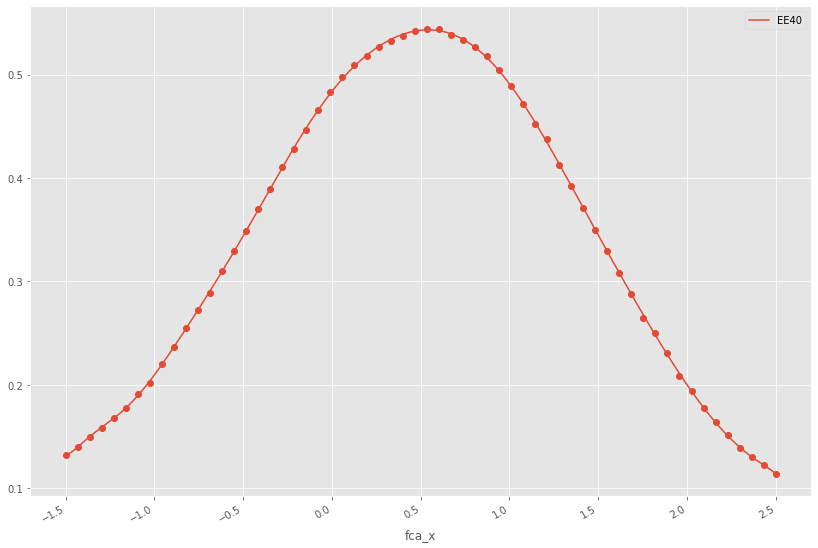

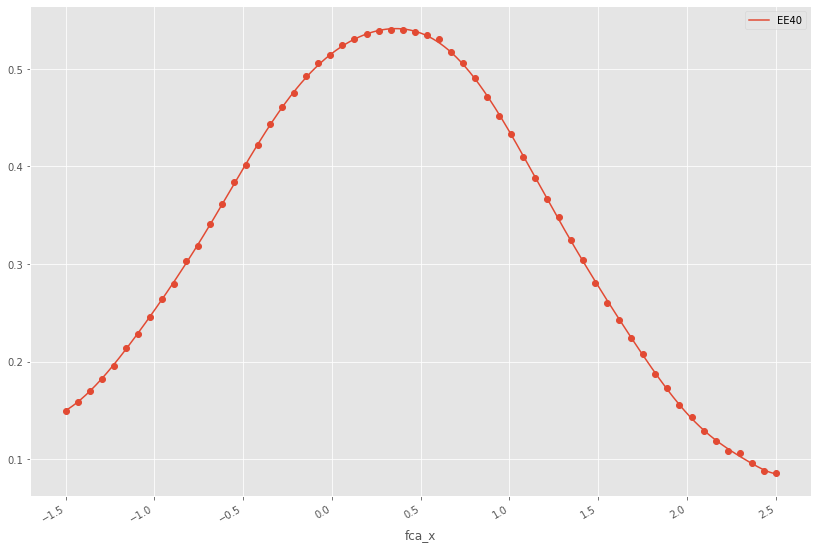

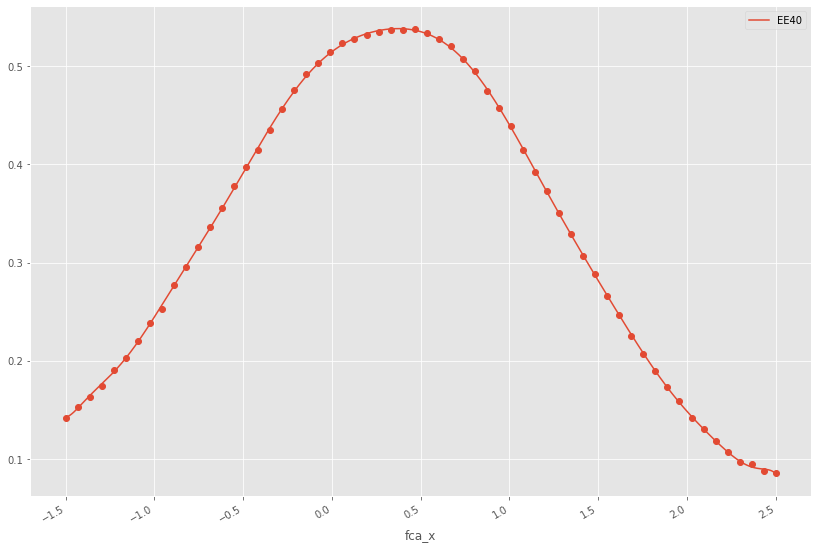

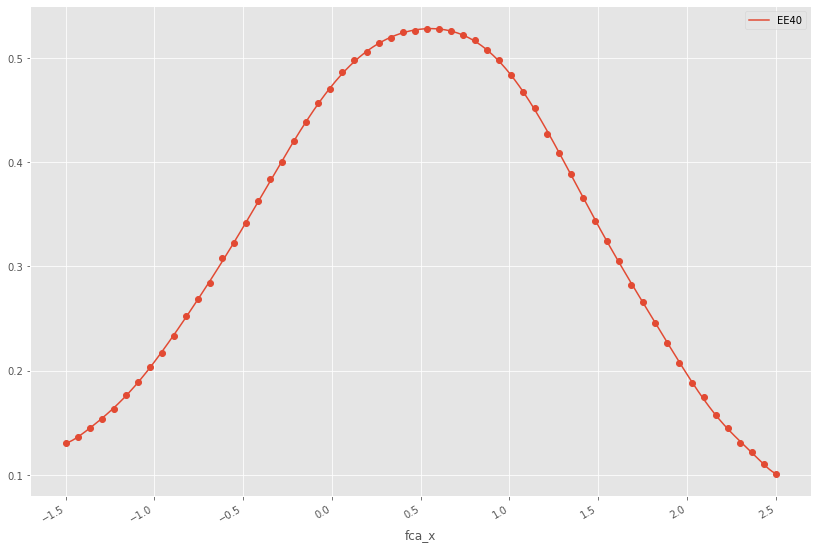

In [24]:
thfocModel= fitFocusData(cube2[cube2.EE40_nbh_flag], corrector=False, doPlot=True, criteria = criteria)

In [25]:
def getFocusModel(fitdata, index='fca_x'):
    data = []
    for experimentId, series in fitdata.groupby('experimentId'):
        series = series.dropna()
        fiber = series['fiber'].unique()[0]
#        for criteria in ['EE20', 'brightness', 'fwhm']:
        for i in [criteria]:

            ixmax = series[i].idxmax() if criteria !='fwhm' else series[i].idxmin()
            focus = series[index][ixmax]
            px = series.px[ixmax]
            py = series.py[ixmax]
            mat = [experimentId, i, px, py, focus, fiber]
            data.append(tuple(mat))
    
    return pd.DataFrame(data, columns=['experimentId', 'criteria', 'px', 'py', index,'fiber'])

In [26]:
focusModel = getFocusModel(thfocModel)

## 4. Tilt & Focus determination

### 4.1. Tilt determination

In [27]:
# 1 : Computing position difference between both extreme fibers
[tilt_ry] = focusModel.fca_x[focusModel.fiber.str.match('\w{3}botend')==True].values - focusModel.fca_x[focusModel.fiber.str.match('\w{3}topend')==True].values

# 2 : Computing tilt on y axis (rad)
angle=np.arctan(tilt_ry/CST_DIST_FIBERS)

# 3 : Converting in degrees
angle_degre=(angle*180)/(np.pi)

print("There is a tilt of",angle_degre, "degrees")

There is a tilt of 0.005606835491344436 degrees


### 4.2. Focus determination

In [28]:
[focus_adjustment] = focusModel.fca_x[focusModel.fiber.str.match('\w{3}botmid')==True].values - focusModel.fca_x[focusModel.fiber.str.match('\w{3}topmid')==True].values
print("You have to adjust the focus by",focus_adjustment, "milimeters")

You have to adjust the focus by 0.01359667666766673 milimeters


## 5. Slit through focus of the framed energy

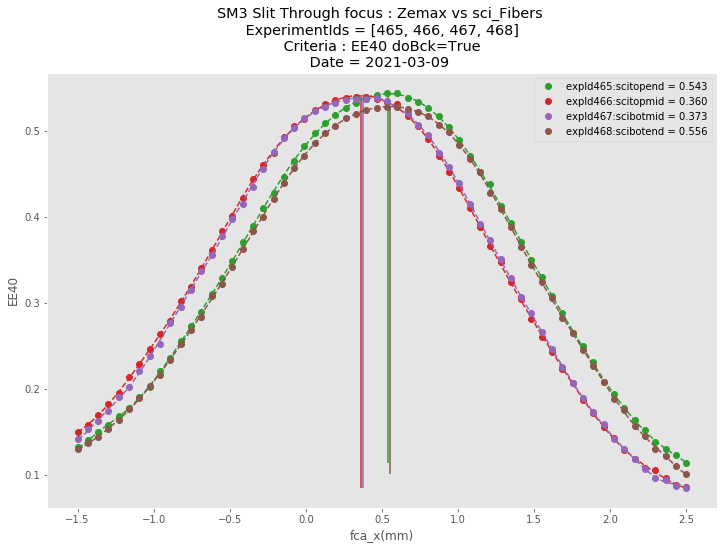

In [29]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(111)
j=2

if criteria == 'EE20' and plotModel:
    ax1.plot(zemaxData.Slitdefocus, zemaxData.MidFiber, '+', color=colors[0], label='Zemax_MidFiber = %.3f' % zemaxMidFit.focus)
    ax1.plot(zemaxMidFit.x, zemaxMidFit.y, '--', color=colors[0])
    if vline:
        ax1.vlines(color=colors[0], **zemaxMidFit.vline)

    ax1.plot(zemaxData.Slitdefocus, zemaxData.ExtremeFiber, '+', color=colors[1], label='Zemax_EndFiber = %.3f' % zemaxEndFit.focus)
    ax1.plot(zemaxEndFit.x, zemaxEndFit.y, '--', color=colors[1])
    if vline:
        ax1.vlines(color=colors[1], **zemaxEndFit.vline)

for experimentId, df in cube2[cube2.EE40_nbh_flag].groupby('experimentId'):
    fit = thfocModel.query("experimentId==%d"%(experimentId))
    focus = focusModel.query("experimentId==%d and criteria=='%s'"%(experimentId, criteria))
    
    ax1.plot(df[index], df[criteria], 'o', color=colors[j], 
             #label='expId%d = %.3f' % (experimentId, experiments.fiber[experimentId]))
             label='expId%d:%s = %.3f' % (experimentId, experiments.fiber[experimentId], focus[index]))

    ax1.plot(fit[index], fit[criteria], '--', color=colors[j])
    
    if vline:
        ax1.vlines(x=focus[index], ymin=fit[criteria].min(), ymax = fit[criteria].max(), color=colors[j])
    j+=1

    
lns = [line for i, line in enumerate(ax1.get_lines()) if not i % 2]
labs = [line.get_label() for line in lns]

ax1.legend(lns, labs)
ax1.set_xlabel('%s(mm)'%index)
ax1.set_ylabel(criteria)

plt.title('%s Slit Through focus : Zemax vs %s_Fibers \n ExperimentIds = %s \n Criteria : %s doBck=%s \n Date = %s  ' %(imgPath[26:29],str(focusModel.fiber[0][:3]),experimentIds,criteria,doBck,datetime.date.today()))
plt.grid()

In [30]:
if doSave : 
    fig.savefig(imgPath+f"Slit_Through_focus_SM{smId}_{focusModel.fiber[0][:3]}_Exp{experimentIds}_{datetime.date.today()}.png") 